# Progeny pathway activities

Please, save the anndata object as follows

```
adata_count = anndata.AnnData(X=np.expm1(adata.raw.X), var=adata.raw.var, obs=adata.obs, asview=False) # if adata.raw is log
```

or

```
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False) # if adata.raw is not log
```

```
sc.pp.filter_genes(adata_count, min_cells=3)
adata_count.write('data/anndata_forSeurat.h5ad')
```


In [10]:
# If problems installing slingshot
# sudo apt-get update
# sudo apt-get install libglu1-mesa-dev 
# sudo apt-get install freeglut3-dev
# sudo apt-get install mesa-common-dev
# then
# install.packages("rgl")
# BiocManager::install("slingshot")
library(Seurat)
library(dplyr)
library(progeny)
library(RColorBrewer)
library(destiny, quietly = TRUE)
library(gam)
library(harmony)
library(ggplot2)
library(pheatmap)
library(cowplot)

In [11]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/jovyan/my-conda-envs/R4/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] splines   stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] cowplot_1.0.0      pheatmap_1.0.12    ggplot2_3.3.0      harmony_1.0       
 [5] Rcpp_1.0.4.6       gam_1.16.1         foreach_1.5.0      destiny_3.2.0     
 [9] RColorBrewer_1.1-2 progeny_1.10.0     dplyr_0.8.5        Seurat_3.1.5      

loaded via a namespace (and not attached):
  [1]

In [12]:
# we know these genes are relevant, use them to keep track on how good we're doing
known_genes = c("LGR6", "WNT7A",  "LHX1", "KRT5", # progenitor 
                         "LGR5", "PDPN", "KRT13", "WIF1", "CCL2", "LYPD1",
                         "MMP7", 
                         "PAEP",  "DPP4", # Early Glandular
                         "SCGB1D2",# Late Glandular
                         "CXCL14", # Only secretory
                         "SEMA3B",  "MUC5B", "MKI67", "PLAU", 'PGR', "SCGB2A1", "VTCN1", "LIF", 'IDH1', 'RCN1')

# Process with Seurat from raw

In [13]:
# Load and pre-process wth standard workflow
anndata <- ReadH5AD(file = 'data/endometrium-N8-epithelial-clean_Luzprocessing_freeze_annot_forSeurat.h5ad')
allgenes = rownames(anndata)
anndata

Pulling expression matrices and metadata

Data is unscaled

Creating assay object

Storing X as raw and raw as counts

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
No variable feature expression found in h5ad file

No dimensional reduction information found

Assembling Seurat object

No nearest-neighbor graph

No additional layers found



An object of class Seurat 
20991 features across 5284 samples within 1 assay 
Active assay: RNA (20991 features, 0 variable features)

In [14]:
# basic preprocessing
anndata <- NormalizeData(anndata, normalization.method = "LogNormalize", scale.factor = 10000)
anndata <- FindVariableFeatures(anndata, nfeatures = 2000)
anndata <- ScaleData(anndata, features = rownames(anndata))

Centering and scaling data matrix



Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 1 features requested have not been scaled (running reduction without them): MLF1IP”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  UBE2C, TOP2A, CDK1, MKI67, TPX2, TYMS, BIRC5, CENPF, NDC80, TACC3 
	   KIF23, AURKB, KIF2C, GTSE1, NUSAP1, HJURP, DLGAP5, KIF11, RRM2, CDCA3 
	   CDCA2, HMGB2, KIF20B, CENPA, CCNB2, RAD51AP1, TTK, HMMR, ANLN, NUF2 
Negative:  UBR7, LBR, CASP8AP2, RANGAP1, G2E3, HN1, RPA2, TIPIN, CTCF, POLA1 
	   PRIM1, TUBB4B, GMNN, MSH2, POLD3, SLBP, MCM5, CHAF1B, USP1, CKAP5 
	   CCNE2, UNG, CBX5, RFC2, ANP32E, CKS2, GAS2L3, MCM2, WDR76, BRIP1 
PC_ 2 
Positive:  GINS2, MCM6, DTL, UHRF1, CDC6, CLSPN, PCNA, UNG, CDC45, MCM5 
	   HELLS, MC

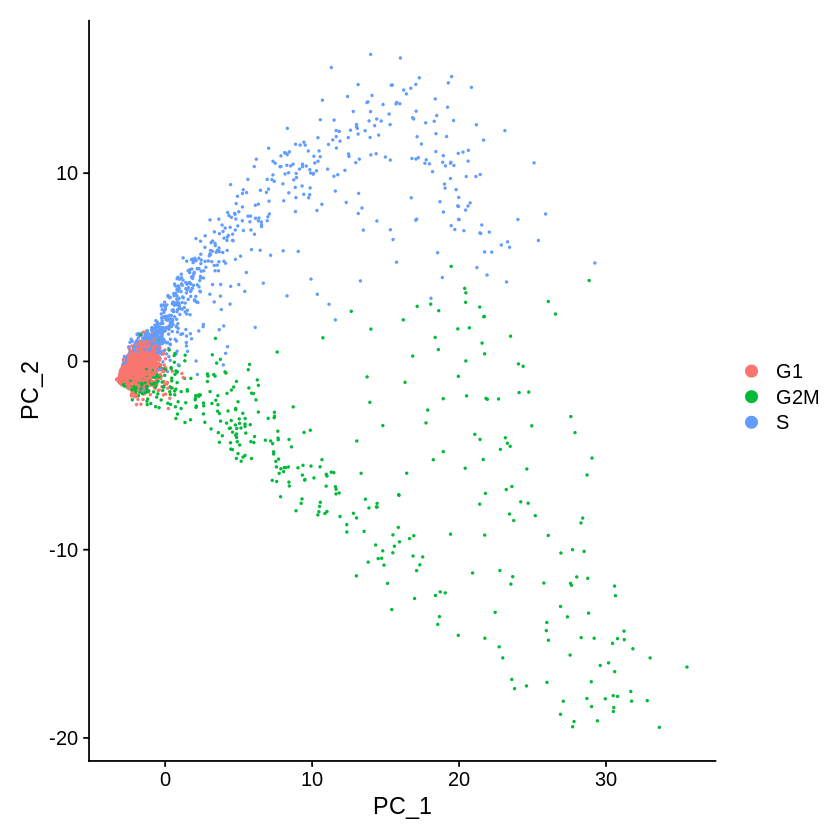

In [15]:
# check cell cycle effect
anndata <- CellCycleScoring(anndata, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes, set.ident = TRUE)
anndata <- RunPCA(anndata, features = c(cc.genes$s.genes, cc.genes$g2m.genes))
DimPlot(anndata, reduction = 'pca')

In [16]:
# # Regress out cell cycle - NOTE: subset the dataset to speed up process
# anndata = subset(anndata, features = VariableFeatures(object = anndata))
# anndata <- ScaleData(anndata, vars.to.regress = c("S.Score", "G2M.Score"), features = rownames(anndata))

PC_ 1 
Positive:  C20orf85, FAM183A, TPPP3, PIFO, RSPH1, C9orf24, CAPSL, SNTN, C1orf194, CFAP126 
	   CCDC78, RP11-356K23.1, ROPN1L, C11orf88, TEKT1, C5orf49, MORN5, FAM216B, ZMYND10, TUBA4B 
	   CFAP53, FAM92B, EFCAB1, DNAAF1, WDR38, ENKUR, LRRC46, OMG, C11orf97, C9orf135 
Negative:  SOD2, PAEP, MGST1, RASD1, IL6ST, TM4SF1, CEBPD, DEFB1, DNAJB1, SGK1 
	   RIMKLB, PAPSS1, LINC01541, C8orf4, GABRP, TPD52L1, ATF3, CXCL8, DUSP2, PLAUR 
	   STC1, ERRFI1, CXCL2, FBLN1, HSPA1A, CYR61, DUSP5, EDN1, GPX3, DYNLT3 
PC_ 2 
Positive:  TYMS, ZWINT, KIAA0101, CDK1, LMNB1, UBE2C, TOP2A, UBE2T, PBK, MKI67 
	   BIRC5, CEP55, CENPF, MND1, MYBL2, TPX2, MAD2L1, NCAPG, RRM2, ESCO2 
	   TACC3, CENPU, NDC80, SPC25, SGOL1, RAD51AP1, CENPW, KIF23, ORC6, TUBA1B 
Negative:  SCGB2A1, NUPR1, RIMKLB, PAEP, S100A6, DEFB1, SLPI, CP, STC1, CLU 
	   PIGR, PDK4, IL6ST, TM4SF1, NNMT, ANG, NEAT1, SOD2, C10orf10, CXCL14 
	   MAOA, PLA2G16, TMSB4X, C4BPA, RASD1, C11orf96, S100A1, PLAUR, HES1, GPX3 
PC_ 3 
Positive:  RIMKLB,

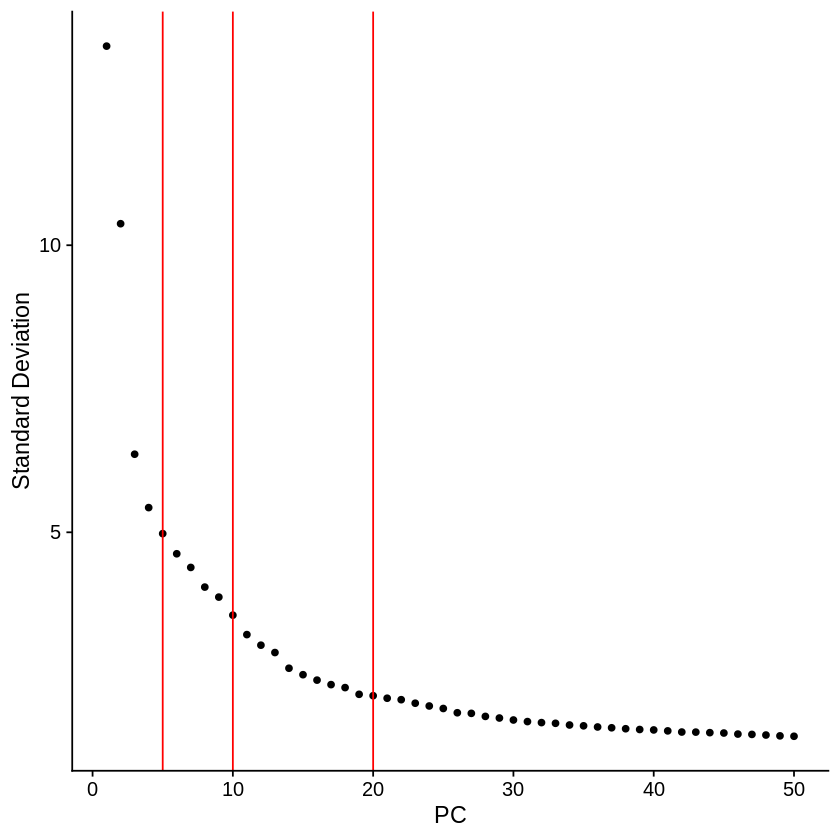

In [17]:
# Compute PCA
anndata <- RunPCA(anndata, features = VariableFeatures(object = anndata), seed.use = 1)
ElbowPlot(anndata, ndims = 50) + geom_vline(xintercept = 5, color = 'red') + geom_vline(xintercept = 10, color = 'red') + geom_vline(xintercept = 20, color = 'red')

In [18]:
npca = 5
# Correct donor's effect on PCA
anndata <- RunHarmony(anndata, group.by.vars = 'type', dims.use = 1:npca, theta = 1)

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [19]:
# Cluster
anndata <- FindNeighbors(anndata, dims = 1:npca, reduction = "harmony")
anndata <- RunUMAP(anndata, dims = 1:npca, reduction = "harmony")

Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:26:58 UMAP embedding parameters a = 0.9922 b = 1.112

10:26:58 Read 5284 rows and found 5 numeric columns

10:26:58 Using Annoy for neighbor search, n_neighbors = 30

10:26:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

10:26:59 Writing NN index file to temp file /tmp/RtmpZQ0pvS/file4d60187edc8c

10:26:59 Searching Annoy index using 1 thread, search_k = 3000

10:27:01 Annoy recall = 100%

10:27:02 Commencing smooth kNN distance cali

In [20]:
anndata <- FindClusters(anndata, resolution = 0.4)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5284
Number of edges: 153938

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9117
Number of communities: 10
Elapsed time: 0 seconds


Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


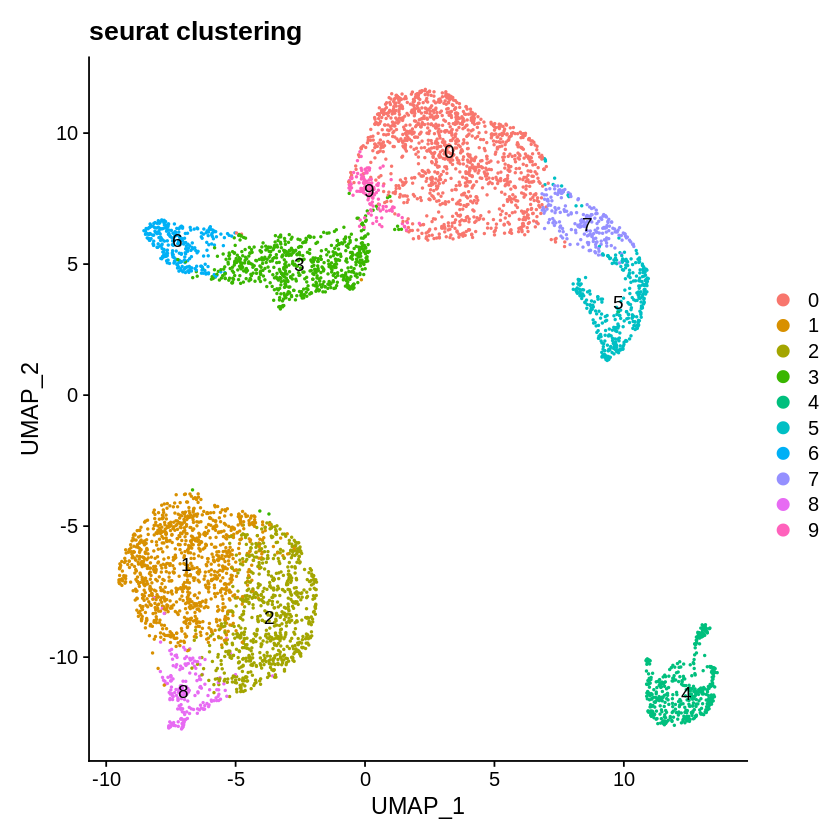

In [21]:
# Visualize
p1 = DimPlot(anndata, reduction = "umap", label = T) + ggtitle('seurat clustering')
p1

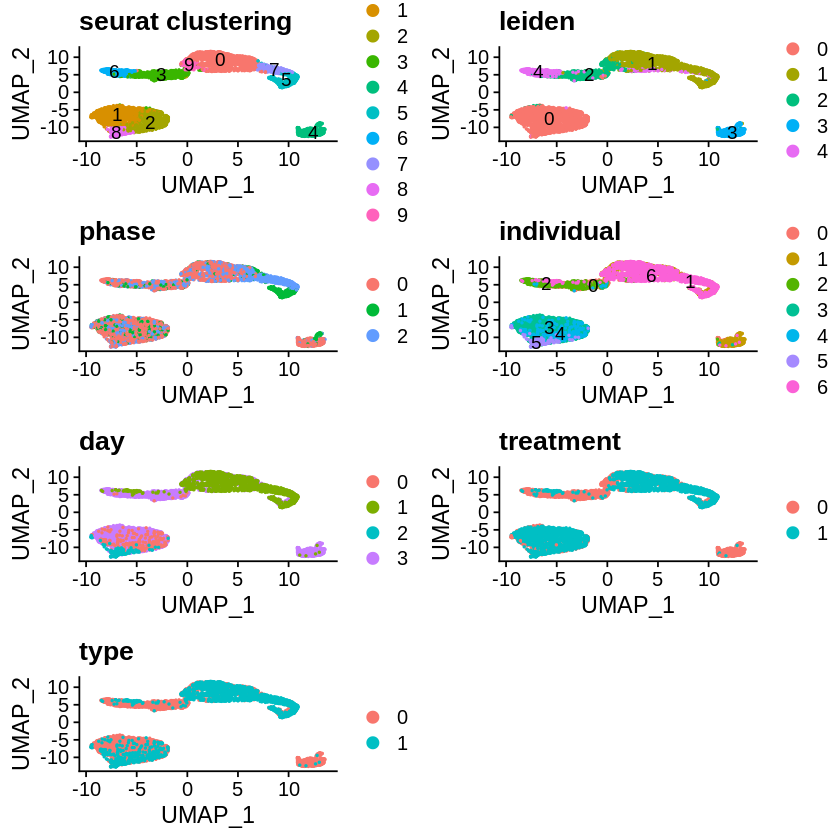

In [22]:
p2 = DimPlot(anndata, reduction = "umap", group.by = 'leiden', label = T) + ggtitle('leiden')
p3 = DimPlot(anndata, reduction = "umap", group.by = 'phase') + ggtitle('phase')
p4 = DimPlot(anndata, reduction = "umap", group.by = 'individual', label = T) + ggtitle('individual')
p5 = DimPlot(anndata, reduction = "umap", group.by = 'day') + ggtitle('day')
p6 = DimPlot(anndata, reduction = "umap", group.by = 'treatment') + ggtitle('treatment')
p7 = DimPlot(anndata, reduction = "umap", group.by = 'type') + ggtitle('type')
plot_grid(p1, p2, p3, p4, p5, p6, p7, ncol = 2)
ggsave(filename = paste0('~/farm/endometrium/figures_primaryEpithelial_clean/seurat_umaps.pdf'), width = 15, height = 20)

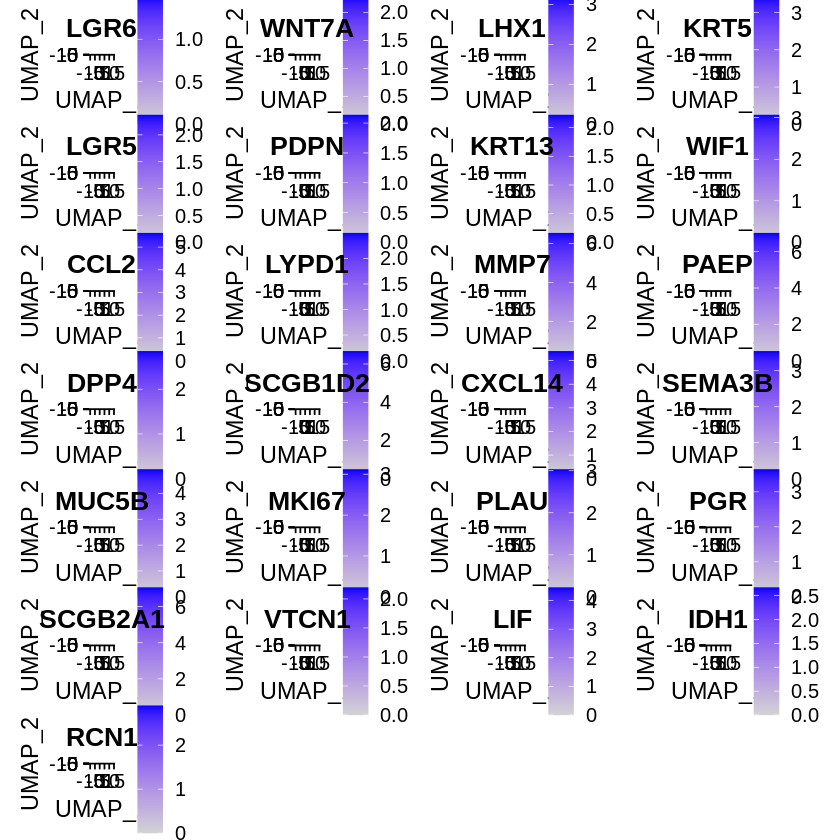

In [23]:
FeaturePlot(anndata, features = known_genes, ncol = 4)
ggsave(filename = paste0('~/farm/endometrium/figures_primaryEpithelial_clean/seurat_markers.pdf'), width = 15, height = 20)

In [24]:
#save
saveRDS(anndata, file = '~/farm/endometrium/figures_primaryEpithelial_clean/seuratobject.rds')

In [25]:
CellsClusters <- data.frame(Cell = names(Idents(anndata)), 
    CellType = as.character(Idents(anndata)),
    stringsAsFactors = FALSE)
head(CellsClusters)

,Cell,CellType
,<chr>,<chr>
1,4861STDY7309368_AACTTTCCAGACGTAG,3
2,4861STDY7309368_AACTTTCCAGTGACAG,3
3,4861STDY7309368_AATCCAGTCAGAAATG,3
4,4861STDY7309368_AATCGGTTCATGTAGC,3
5,4861STDY7309368_ACACCAACAGGCTGAA,3
6,4861STDY7309368_ACACCCTGTATTCGTG,4


In [26]:
## We compute the Progeny activity scores and add them to our Seurat object
## as a new assay called Progeny. 
x <- progeny(expr = anndata@assays$RNA@scale.data, scale = FALSE)

In [27]:
anndata[['progeny']] = CreateAssayObject(counts = t(x))

In [28]:
x[1:5, 1:5]

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT
4861STDY7309368_AACTTTCCAGACGTAG,59.58775,-22.770657,-65.321490,-77.86685,-66.46880
4861STDY7309368_AACTTTCCAGTGACAG,23.35259,2.663208,4.772603,240.41497,290.12371
4861STDY7309368_AATCCAGTCAGAAATG,-8.29286,-39.149026,-26.005438,36.58880,400.15369
4861STDY7309368_AATCGGTTCATGTAGC,-53.21280,-31.406233,-112.952200,-11.75305,-47.29386
4861STDY7309368_ACACCAACAGGCTGAA,-115.47595,-36.963925,-84.131885,-170.89450,96.52657


In [29]:
## We can now directly apply Seurat functions in our Progeny scores. 
## For instance, we scale the pathway activity scores. 
anndata <- Seurat::ScaleData(anndata, assay = "progeny") 

Centering and scaling data matrix



In [30]:
progeny_scores_df <- sapply(levels(Idents(anndata)), function(le) apply(x[subset(CellsClusters, CellType == le)$Cell,], 2, mean)  ) 

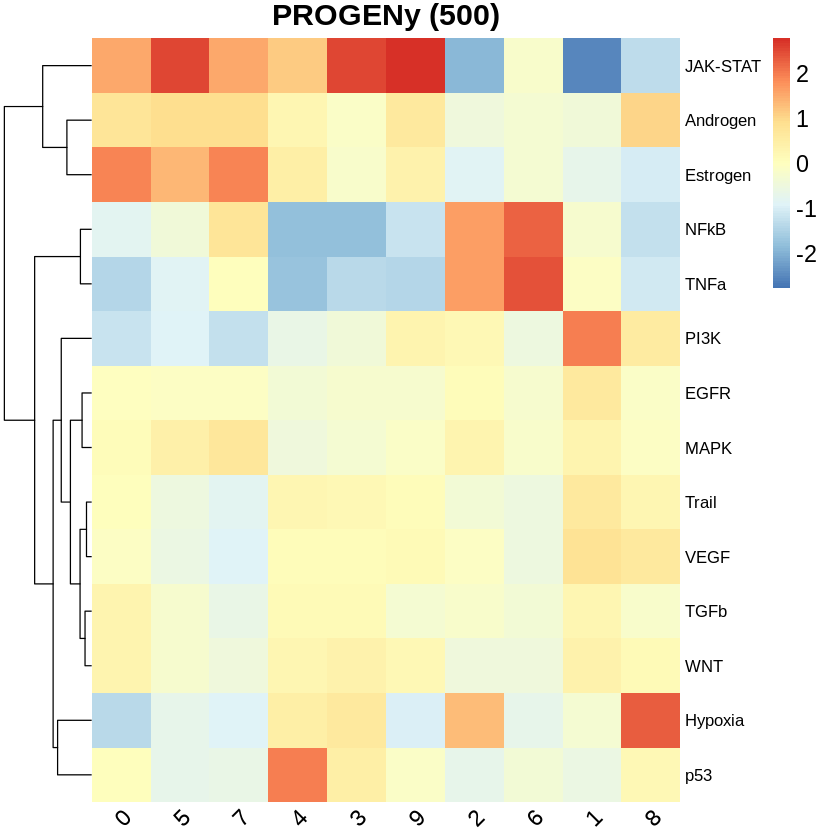

In [39]:
pheatmap(progeny_scores_df,fontsize=14, scale = 'column', 
                        fontsize_row = 10, 
                        main = "PROGENy (500)", angle_col = 45,
                        treeheight_col = 0,  border_color = NA)